# SpotFake: Twitter Fake News Detection - Training & Inference

This notebook provides a clean implementation for:
1. Loading and preprocessing data (text + images)
2. Building the multimodal model (BERT + VGG19)
3. Training the model
4. Making predictions on new inputs (text + image)

In [1]:
# !python -m venv .venv
# !.venv\Scripts\Activate.ps1
# !pip install -r requirements.txt

## 1. Imports and Setup

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from os import listdir
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
import tensorflow_hub as hub
from transformers import BertTokenizer
from tensorflow.keras import backend as K

import gc

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Suppress TF warnings
tf.get_logger().setLevel('ERROR')

print("TensorFlow version:", tf.__version__)
print("✓ All imports successful!")

d:\ML\SpotFake02\.venv\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version



TensorFlow version: 2.20.0
✓ All imports successful!


In [3]:
# Configuration
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 23
img_length = 224
img_width = 224
img_channels = 3

## 2. Helper Functions

In [4]:
# Progress callback
def live():
    """Simple callback for training progress"""
    return tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(
            f"Epoch {epoch + 1}: loss={logs.get('loss', 0):.4f}, "
            f"acc={logs.get('accuracy', 0):.4f}, "
            f"val_loss={logs.get('val_loss', 0):.4f}, "
            f"val_acc={logs.get('val_accuracy', 0):.4f}"
        )
    )

### Text Preprocessing Functions

In [5]:
class PaddingInputExample(object):
    """Fake example for padding."""

class InputExample(object):
    """A single training/test example for simple sequence classification."""
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the BERT tokenizer."""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single InputExample into features."""
    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    encoding = tokenizer(
        example.text_a,
        truncation=True,
        padding='max_length',
        max_length=max_seq_length,
        return_tensors='tf'
    )
    
    input_ids = encoding['input_ids'][0].numpy().tolist()
    input_mask = encoding['attention_mask'][0].numpy().tolist()
    segment_ids = [0] * max_seq_length
    
    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of InputExamples to features."""
    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples from texts and labels."""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text if isinstance(text, str) else " ".join(text), text_b=None, label=label)
        )
    return InputExamples

def preprocess_text_input(text, tokenizer, max_seq_length=23):
    """Preprocess a single text input for prediction."""
    example = InputExample(guid=None, text_a=text, text_b=None, label=0)
    input_id, input_mask, segment_id, _ = convert_single_example(
        tokenizer, example, max_seq_length
    )
    return np.array([input_id]), np.array([input_mask]), np.array([segment_id])

print("✓ Text preprocessing functions defined")

✓ Text preprocessing functions defined


### Image Preprocessing Functions

In [6]:
def read_and_process_image(list_of_images, length=224, width=224):
    """Read and preprocess multiple images."""
    X = [] 
    for image in tqdm(list_of_images, desc="Processing images"):
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (length, width), interpolation=cv2.INTER_CUBIC))  
    return np.array(X)

def preprocess_single_image(image_path, length=224, width=224):
    """Preprocess a single image for prediction."""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    img = cv2.resize(img, (length, width), interpolation=cv2.INTER_CUBIC)
    # Convert to (channels, height, width) format
    img = np.rollaxis(img, 2, 0)
    return np.expand_dims(img, axis=0)  # Add batch dimension

print("✓ Image preprocessing functions defined")

✓ Image preprocessing functions defined


## 3. Model Definition

In [7]:
def get_news_model(params):
    """Build the multimodal fake news detection model."""
    tf.keras.backend.clear_session()
    
    # BERT encoder function
    def bert_encode(input_ids, input_mask, segment_ids):
        bert_layer = hub.KerasLayer(
            bert_path,
            trainable=False,
            signature="tokens",
            signature_outputs_as_dict=True,
        )
        bert_inputs = {
            "input_ids": input_ids, 
            "input_mask": input_mask, 
            "segment_ids": segment_ids
        }
        bert_outputs = bert_layer(bert_inputs)
        return bert_outputs["pooled_output"]

    # Text input branch
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype=tf.int32)
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks", dtype=tf.int32)
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids", dtype=tf.int32)
    
    bert_output = tf.keras.layers.Lambda(
        lambda inputs: bert_encode(inputs[0], inputs[1], inputs[2]),
        output_shape=(768,),
        name="bert_encoding"
    )([in_id, in_mask, in_segment])

    if params['text_no_hidden_layer'] > 0:
        for i in range(params['text_no_hidden_layer']):
            bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
            bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

    text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

    # Image input branch (VGG19)
    conv_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    conv_base.trainable = False

    input_image = tf.keras.layers.Input(shape=(3, 224, 224))
    transposed_image = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(input_image)
    base_output = conv_base(transposed_image)
    flat = tf.keras.layers.Flatten()(base_output)

    if params['vis_no_hidden_layer'] > 0:
        for i in range(params['vis_no_hidden_layer']):
            flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
            flat = tf.keras.layers.Dropout(params['dropout'])(flat)

    visual_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(flat)

    # Classifier (combine text + image)
    combine_repr = tf.keras.layers.concatenate([text_repr, visual_repr])
    com_drop = tf.keras.layers.Dropout(params['dropout'])(combine_repr)

    if params['final_no_hidden_layer'] > 0:
        for i in range(params['final_no_hidden_layer']):
            com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
            com_drop = tf.keras.layers.Dropout(params['dropout'])(com_drop)

    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(com_drop)

    model = tf.keras.models.Model(inputs=[in_id, in_mask, in_segment, input_image], outputs=prediction)
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    
    return model

print("✓ Model definition ready")

✓ Model definition ready


## 4. Load and Preprocess Data

In [8]:
# Load datasets
def get_df(file):
    return pd.read_csv(file, sep='\t')

train_df = get_df('dataset/twitter/train_posts.txt')
test_df = get_df('dataset/twitter/test_posts.txt')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
train_df.head()

Train shape: (15629, 7)
Test shape: (2177, 7)


,post_id,post_text,user_id,image_id,username,timestamp,label
0,324597532548276224,Don't need feds to solve the #bostonbombing wh...,886672620,"boston_fake_03,boston_fake_35",SantaCruzShred,Wed Apr 17 18:57:37 +0000 2013,fake
1,325145334739267584,PIC: Comparison of #Boston suspect Sunil Tripa...,21992286,boston_fake_23,Oscar_Wang,Fri Apr 19 07:14:23 +0000 2013,fake
2,325152091423248385,I'm not completely convinced that it's this Su...,16428755,boston_fake_34,jamwil,Fri Apr 19 07:41:14 +0000 2013,fake
3,324554646976868352,Brutal lo que se puede conseguir en colaboraci...,303138574,"boston_fake_03,boston_fake_35",rubenson80,Wed Apr 17 16:07:12 +0000 2013,fake
4,324315545572896768,4chan and the bombing. just throwing it out th...,180460772,boston_fake_15,Slimlenny,Wed Apr 17 00:17:06 +0000 2013,fake


In [9]:
# Extract first image ID
def return_first_image(row):
    return row['image_id'].split(',')[0].strip()

train_df['first_image_id'] = train_df.progress_apply(lambda row: return_first_image(row), axis=1)
test_df['first_image_id'] = test_df.progress_apply(lambda row: return_first_image(row), axis=1)

  0%|          | 0/15629 [00:00<?, ?it/s]

  0%|          | 0/2177 [00:00<?, ?it/s]

In [10]:
# Filter out missing images
images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('dataset/twitter/images_train')]
images_train_not_available = set(images_train_dataset) - set(images_train_folder)
images_train_not_available.add('boston_fake_10')

images_test_dataset = [i.split(',')[0].strip() for i in test_df['image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('dataset/twitter/images_test/')]
images_test_not_available = set(images_test_dataset) - set(images_test_folder)

train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]

print(f"After filtering - Train: {train_df.shape}, Test: {test_df.shape}")

After filtering - Train: (13754, 8), Test: (1001, 8)


In [11]:
# Extract text and labels
train_text = train_df['post_text'].tolist()
test_text = test_df['post_text'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i for i in test_df['first_image_id'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i == 'real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i == 'real' else 0 for i in testY]

print(f"Data counts: {len(train_text)} train, {len(test_text)} test")

Data counts: 13754 train, 1001 test


### Process Text Data

In [12]:
# Initialize tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, trainY_processed
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)

(test_input_ids, test_input_masks, test_segment_ids, testY_processed
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

print(f"Text features shape: {train_input_ids.shape}")

Converting examples to features:   0%|          | 0/13754 [00:00<?, ?it/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Converting examples to features:   0%|          | 0/1001 [00:00<?, ?it/s]

Text features shape: (13754, 23)


### Process Image Data

In [13]:
# Get image file extensions
images = listdir('dataset/twitter/images_train/')
images.extend(listdir('dataset/twitter/images_test/'))
jpg, png, jpeg, gif = [], [], [], []

valid_extensions = {'jpg', 'png', 'jpeg', 'gif'}
for i in images:
    if '.' not in i or i.startswith('.'):
        continue
    name, ext = i.split('.')[0], i.split('.')[-1].lower()
    if ext in valid_extensions:
        if ext == 'jpg':
            jpg.append(name)
        elif ext == 'png':
            png.append(name)
        elif ext == 'jpeg':
            jpeg.append(name)
        elif ext == 'gif':
            gif.append(name)

def get_extension_of_file(file_name):
    if file_name in jpg:
        return '.jpg'
    elif file_name in png:
        return '.png'
    elif file_name in jpeg:
        return '.jpeg'
    else:
        return '.gif'

print(f"Found: {len(jpg)} jpg, {len(png)} png, {len(jpeg)} jpeg, {len(gif)} gif")

Found: 1024 jpg, 2 png, 0 jpeg, 2 gif


In [14]:
# Build full image paths
train_image_paths = ['dataset/twitter/images_train/' + i + get_extension_of_file(i) for i in train_images]
test_image_paths = ['dataset/twitter/images_test/' + i + get_extension_of_file(i) for i in test_images]

In [15]:
# Option 1: Load from saved .npy files (if available)
try:
    train_imagesX = np.load('train_imagesX.npy')
    test_imagesX = np.load('test_imagesX.npy')
    print("✓ Loaded preprocessed images from .npy files")
except FileNotFoundError:
    print("Processing images from scratch (this may take a while)...")
    train_imagesX = read_and_process_image(train_image_paths)
    test_imagesX = read_and_process_image(test_image_paths)
    
    # Save for future use
    np.save('train_imagesX.npy', train_imagesX)
    np.save('test_imagesX.npy', test_imagesX)
    print("✓ Saved preprocessed images to .npy files")

# Convert to (batch, channels, height, width) format
train_imagesX = np.rollaxis(train_imagesX, 3, 1)
test_imagesX = np.rollaxis(test_imagesX, 3, 1)

print(f"Image data shape: {train_imagesX.shape}")

✓ Loaded preprocessed images from .npy files
Image data shape: (13754, 3, 224, 224)


## 5. Model Training

In [16]:
# Best hyperparameters (from hyperparameter search)
params_final = {
    'text_no_hidden_layer': 1,
    'text_hidden_neurons': 768,
    'dropout': 0.4,
    'repr_size': 32,
    'vis_no_hidden_layer': 1,
    'vis_hidden_neurons': 2742,
    'final_no_hidden_layer': 1,
    'final_hidden_neurons': 35,
    'optimizer': tf.keras.optimizers.Adam
}

print("Model parameters:")
for k, v in params_final.items():
    print(f"  {k}: {v}")

Model parameters:
  text_no_hidden_layer: 1
  text_hidden_neurons: 768
  dropout: 0.4
  repr_size: 32
  vis_no_hidden_layer: 1
  vis_hidden_neurons: 2742
  final_no_hidden_layer: 1
  final_hidden_neurons: 35
  optimizer: <class 'keras.src.optimizers.adam.Adam'>


In [17]:
# Build model
model = get_news_model(params_final)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_masks         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 7, 7, 512) │ 20,024,384 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoding       │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ input_masks[0][0… │
│                     │                   │            │ segment_ids[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg19[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 768)       │    590,592 │ bert_encoding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2742)      │ 68,794,038 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2742)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     24,608 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │     87,776 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 35)        │      2,275 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 35)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         36 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,523,709 (341.51 MB)

 Trainable params: 69,499,325 (265.12 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [18]:
# Set learning rate
model.optimizer.learning_rate.assign(0.0005)
print(f"Learning rate set to: {model.optimizer.learning_rate.numpy()}")

Learning rate set to: 0.0005000000237487257


In [22]:
# Setup checkpoint callback - DISABLED due to disk space
# Note: Checkpoint is commented out to avoid "No space left on device" errors
# You can save the model manually after training using model.save_weights()

# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     'model_weights_{epoch:03d}_{val_accuracy:.4f}.weights.h5', 
#     verbose=1, 
#     monitor='val_accuracy',
#     save_best_only=True,
#     save_weights_only=True,
#     mode='max'
# )

# Early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,  # Keeps best weights in memory
    verbose=1
)

print("✓ Training callbacks configured (checkpoint disabled to save disk space)")

✓ Checkpoint callback configured


In [23]:
# Train the model
print("Starting training...\n")

history = model.fit(
    [train_input_ids, train_input_masks, train_segment_ids, train_imagesX], 
    trainY_processed,
    batch_size=256,  # Increased batch size for efficiency
    epochs=20,       # Full training epochs
    verbose=1,
    shuffle=True,
    validation_data=(
        [test_input_ids, test_input_masks, test_segment_ids, test_imagesX],
        testY_processed
    ),
    callbacks=[early_stop]  # Only using early stopping (best weights kept in memory)
)

print("\n✓ Training completed!")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

Starting training...

Epoch 1/20
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.7621 - loss: 0.5278 
Epoch 1: val_accuracy improved from None to 0.50250, saving model to model_weights_001_0.5025.weights.h5

Epoch 1: val_accuracy improved from None to 0.50250, saving model to model_weights_001_0.5025.weights.h5


OSError: [Errno 28] Can't synchronously write data (file write failed: time = Wed Oct 15 04:08:26 2025
, filename = 'model_weights_001_0.5025.weights.h5', file descriptor = 4, errno = 28, error message = 'No space left on device', buf = 0000017778E61040, total write size = 9437184, bytes this sub-write = 9437184, offset = 61289672)

NameError: name 'history' is not defined

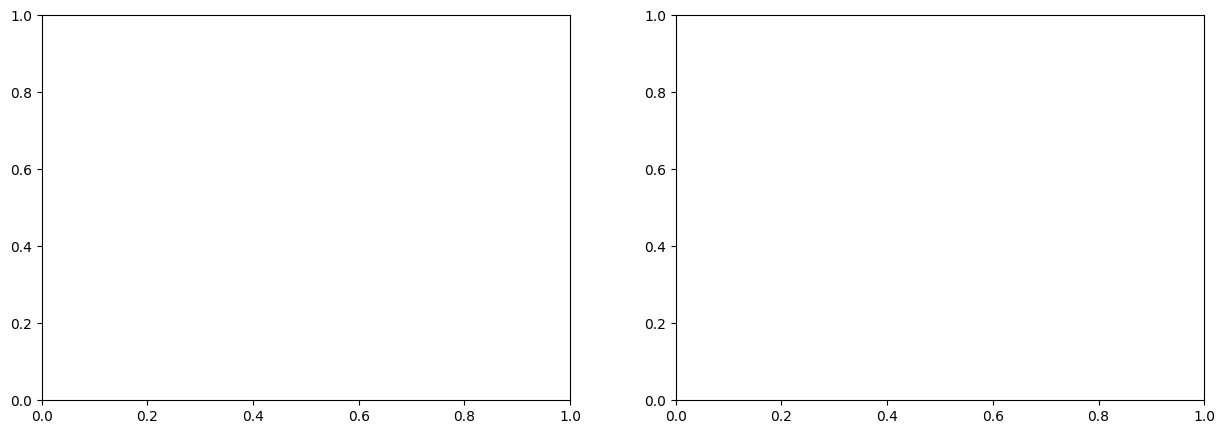

In [21]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

## 6. Model Evaluation

In [ ]:
# Load best model weights if needed (update filename with your best checkpoint)
# Example: model.load_weights('model_weights_010_0.7769.weights.h5')

# Or evaluate current model (after training)
test_predictions = model.predict([
    test_input_ids, test_input_masks, test_segment_ids, test_imagesX
])
test_predictions_binary = [1 if i >= 0.5 else 0 for i in test_predictions]

print("Test Set Evaluation:")
print(f"Accuracy:  {accuracy_score(testY_processed, test_predictions_binary):.4f}")
print(f"F1 Score:  {f1_score(testY_processed, test_predictions_binary, average=None)}")
print(f"Precision: {precision_score(testY_processed, test_predictions_binary, average=None)}")
print(f"Recall:    {recall_score(testY_processed, test_predictions_binary, average=None)}")

## 7. Inference on New Input

Use this section to make predictions on new text + image pairs.

In [ ]:
def predict_fake_news(text, image_path, model, tokenizer, threshold=0.5):
    """
    Predict whether a news post (text + image) is fake or real.
    
    Args:
        text (str): The post text
        image_path (str): Path to the image file
        model: Trained Keras model
        tokenizer: BERT tokenizer
        threshold (float): Classification threshold (default 0.5)
    
    Returns:
        dict: Prediction results
    """
    # Preprocess text
    input_ids, input_masks, segment_ids = preprocess_text_input(
        text, tokenizer, max_seq_length=max_seq_length
    )
    
    # Preprocess image
    image_data = preprocess_single_image(image_path, length=img_length, width=img_width)
    
    # Make prediction
    prediction = model.predict(
        [input_ids, input_masks, segment_ids, image_data],
        verbose=0
    )[0][0]
    
    # Classify
    is_real = prediction >= threshold
    label = "REAL" if is_real else "FAKE"
    confidence = prediction if is_real else (1 - prediction)
    
    return {
        'label': label,
        'confidence': float(confidence),
        'raw_score': float(prediction),
        'text': text,
        'image_path': image_path
    }

print("✓ Inference function ready")

### Example: Make a Prediction

In [ ]:
# Example usage
# Replace with your own text and image path

sample_text = "Breaking news: Major event happening now!"
sample_image_path = test_image_paths[0]  # Using first test image as example

result = predict_fake_news(sample_text, sample_image_path, model, tokenizer)

print("\n" + "="*50)
print("PREDICTION RESULT")
print("="*50)
print(f"Text: {result['text']}")
print(f"Image: {result['image_path']}")
print(f"\nPrediction: {result['label']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Raw Score: {result['raw_score']:.4f}")
print("="*50)

# Display the image
img = cv2.imread(sample_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.title(f"Prediction: {result['label']} ({result['confidence']:.2%} confidence)")
plt.axis('off')
plt.show()

### Batch Prediction on Multiple Inputs

In [ ]:
def predict_batch(texts, image_paths, model, tokenizer, threshold=0.5):
    """
    Make predictions on multiple text-image pairs.
    
    Args:
        texts (list): List of text strings
        image_paths (list): List of image file paths
        model: Trained Keras model
        tokenizer: BERT tokenizer
        threshold (float): Classification threshold
    
    Returns:
        list: List of prediction dictionaries
    """
    results = []
    for text, img_path in tqdm(zip(texts, image_paths), total=len(texts), desc="Making predictions"):
        try:
            result = predict_fake_news(text, img_path, model, tokenizer, threshold)
            results.append(result)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            results.append({
                'label': 'ERROR',
                'confidence': 0.0,
                'raw_score': 0.0,
                'text': text,
                'image_path': img_path,
                'error': str(e)
            })
    return results

print("✓ Batch prediction function ready")

In [ ]:
# Example: Predict on first 5 test samples
sample_size = 5
sample_texts = test_text[:sample_size]
sample_images = test_image_paths[:sample_size]
sample_labels = testY[:sample_size]

predictions = predict_batch(sample_texts, sample_images, model, tokenizer)

# Display results
print("\n" + "="*80)
print("BATCH PREDICTION RESULTS")
print("="*80)
for i, (pred, true_label) in enumerate(zip(predictions, sample_labels)):
    true_label_str = "REAL" if true_label == 1 else "FAKE"
    match = "✓" if pred['label'] == true_label_str else "✗"
    print(f"\nSample {i+1}:")
    print(f"  Text: {pred['text'][:50]}...")
    print(f"  True Label: {true_label_str}")
    print(f"  Predicted: {pred['label']} ({pred['confidence']:.2%}) {match}")
print("="*80)

## 8. Save/Load Model

In [ ]:
# Save the model weights (more reliable than saving entire model)
model.save_weights('spotfake_final_weights.weights.h5')
print("✓ Model weights saved to 'spotfake_final_weights.weights.h5'")

# To load the weights later:
# 1. First rebuild the model with same architecture
# model = get_news_model(params_final)
# 2. Then load the weights
# model.load_weights('spotfake_final_weights.weights.h5')

# Alternative: Save entire model (if needed for deployment)
try:
    model.save('spotfake_final_model.keras')  # Using new Keras format
    print("✓ Full model saved to 'spotfake_final_model.keras'")
except Exception as e:
    print(f"Note: Could not save full model: {e}")
    print("Use save_weights() instead for more reliable saving.")

## Summary

This notebook provides:

1. **Data Loading & Preprocessing**: Load Twitter fake news dataset with text and images
2. **Model Architecture**: Multimodal model combining BERT (text) + VGG19 (image)
3. **Training**: Train the model with optimal hyperparameters
4. **Evaluation**: Comprehensive metrics on test set
5. **Inference**: Easy-to-use functions for predicting on new inputs

### To use this notebook:

1. Run all cells in order to train the model
2. Use `predict_fake_news()` for single predictions
3. Use `predict_batch()` for multiple predictions
4. Load saved weights with `model.load_weights()` to skip training

### For new predictions:

```python
# Your custom input
my_text = "Your news text here"
my_image = "path/to/your/image.jpg"

# Get prediction
result = predict_fake_news(my_text, my_image, model, tokenizer)
print(f"Prediction: {result['label']} (Confidence: {result['confidence']:.2%})")
```